<a href="https://colab.research.google.com/github/agrudkow/tass-project-1/blob/master/notebooks/TASS_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalacja NetowrkX

In [59]:
pip install networkx

In [60]:
import logging
from os import path

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logging.basicConfig()
logger = logging.getLogger('TASS')
logger.setLevel(logging.DEBUG)
plt.rcParams.update({'font.size': 22})

# Definiowanie stałych

In [61]:
GRAPH_FILENAME = 'graph_4.txt' #@param {type:"string"}
GRAPH_URL = 'https://www.ia.pw.edu.pl/~mkamola/dataset-big/4.txt' #@param {type:"string"}
GRAPH_DIR = '.' #@param {type:"string"}

# Zbiór danych
Numer zbioru danych badanego w zadaniu to **4**.

In [62]:
!curl {GRAPH_URL} -o {GRAPH_DIR}/{GRAPH_FILENAME}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3622k  100 3622k    0     0  1768k      0  0:00:02  0:00:02 --:--:-- 1768k


# Wczytanie grafu

In [63]:
df = pd.read_csv(path.join(GRAPH_DIR, GRAPH_FILENAME))
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(df, create_using=Graphtype)

# Rząd i rozmiar sieci

In [64]:
print(f'Rząd: {G.number_of_nodes()}')
print(f'Rozmiar: {G.number_of_edges()}')

Rząd: 20375
Rozmiar: 155925


# Usunięcie pętli i duplikatów krawędzi (zamiana grafu na nieskierowany)

In [65]:
G.remove_edges_from(nx.selfloop_edges(G))
G = G.to_undirected()

# Rząd i rozmiar sieci

In [66]:
print(f'Rząd: {G.number_of_nodes()}')
print(f'Rozmiar: {G.number_of_edges()}')


Rząd: 20375
Rozmiar: 155598


# Wyodrębnienie największej (i najmniejszej) składowej spójnej

In [67]:
cc = nx.connected_components(G)
cc = sorted(cc, key=lambda x: len(x), reverse=True)
G_lcc = G.subgraph(cc[0]).copy()
G_scc = G.subgraph(cc[-1]).copy()

# Rząd i rozmiar największej (i najmniejszej) składowej spójnej

In [68]:
print(f'Rząd największej składowej spójenej: {G_lcc.number_of_nodes()}')
print(f'Rozmiar największej składowej spójenej: {G_lcc.number_of_edges()}')

Rząd największej składowej spójenej: 20373
Rozmiar największej składowej spójenej: 155597


Rząd najmniejszje składowej spójenej: 2
Rozmiar najmniejszej składowej spójenej: 1


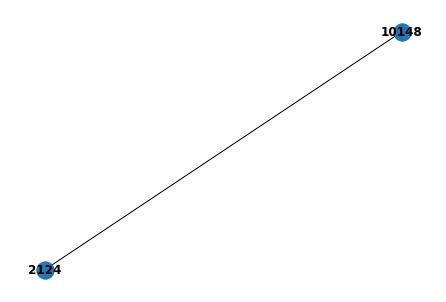

In [69]:
print(f'Rząd najmniejszje składowej spójenej: {G_scc.number_of_nodes()}')
print(f'Rozmiar najmniejszej składowej spójenej: {G_scc.number_of_edges()}')
nx.draw(G_scc, with_labels=True, font_weight='bold')

# Wyznacz aproksymacje średniej długości ścieżki, operując na próbie losowej 100, 1000 i 10 tys. par wierzchołków

In [70]:
from random import choices

def calc_avg_path_len(graph, pairs_num: int) -> float:
  paths_lengths = []
  graph_nodes = list(graph.nodes())
  for _ in range(pairs_num):
    source, target = choices(graph_nodes, k=2) # Losuj ze zwracaniem
    lenght = nx.shortest_path_length(graph, source=source, target=target)
    paths_lengths.append(lenght)
  
  return np.mean(paths_lengths)



In [71]:
avg_path_len_100 = calc_avg_path_len(G_lcc, 100)
avg_path_len_1000 = calc_avg_path_len(G_lcc, 1000)
avg_path_len_10000 = calc_avg_path_len(G_lcc, 10000)

Avg dla 100: 4.14
Avg dla 1000: 4.07
Avg dla 10000: 4.1043


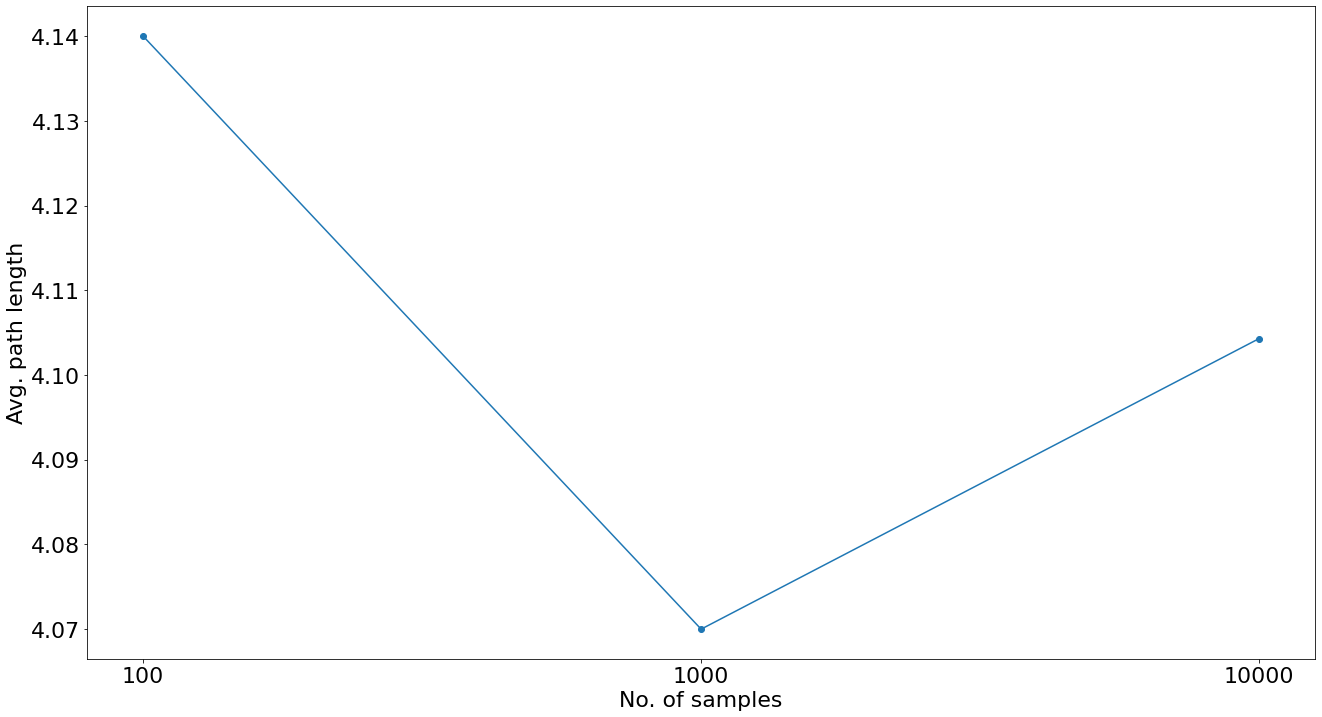

In [72]:
print(f'Avg dla 100: {avg_path_len_100}')
print(f'Avg dla 1000: {avg_path_len_1000}')
print(f'Avg dla 10000: {avg_path_len_10000}')

fig = plt.figure(figsize =(22, 12))
plt.plot(['100', '1000', '10000'], [avg_path_len_100, avg_path_len_1000, avg_path_len_10000], '-o')
plt.ylabel("Avg. path length")
plt.xlabel("No. of samples")
plt.show()

# Wyznacz liczbę rdzeni o największym możliwym rzędzie, o drugim możliwie największym rzędzie o trzecim możliwie największym rzędzie; jakie to są rzędy?

In [73]:

def find_top_3_k_cores(graph):
  nodes_dir = {}
  last = None
  k=1
  while len(nodes_dir) < 4:
    logger.info(f'Finding k-cores for k={k}.')
    nodes_num = len(nx.k_core(G_lcc, k=k))
    logger.info(f'Found {nodes_num} vertices.')
    if nodes_num in nodes_dir:
      nodes_dir[nodes_num].append(k)
    else:
      nodes_dir[nodes_num] = [k]
    last = nodes_num
    k += 1
  
  del nodes_dir[last]
  return nodes_dir

In [74]:
result = find_top_3_k_cores(G_lcc)

INFO:TASS:Finding k-cores for k=1.
INFO:TASS:Found 20373 vertices.
INFO:TASS:Finding k-cores for k=2.
INFO:TASS:Found 20030 vertices.
INFO:TASS:Finding k-cores for k=3.
INFO:TASS:Found 19281 vertices.
INFO:TASS:Finding k-cores for k=4.
INFO:TASS:Found 18261 vertices.


In [75]:
print(result)

{20373: [1], 20030: [2], 19281: [3]}


# Wykreśl rozkład stopni wierzchołków

In [106]:
from collections import Counter
def calc_degree_distribution(graph):
  degree_freq = nx.degree_histogram(graph)[1:]
  degree_freq_cum_sum = np.cumsum(degree_freq)
  complementary_degree_freq_cum_sum = np.max(degree_freq_cum_sum) - degree_freq_cum_sum
  degrees = np.array(range(1, len(degree_freq) + 1))

  return degree_freq, degree_freq_cum_sum, complementary_degree_freq_cum_sum, degrees

def plot_degree_dist(degree_freq, degree_freq_cum_sum, complementary_degree_freq_cum_sum, degrees):
  plt.figure(figsize=(22, 12))
  plt.loglog(degrees, degree_freq,'bo') 
  plt.loglog(degrees, complementary_degree_freq_cum_sum,'go') 
  plt.xlabel('Degree')
  plt.ylabel('Frequency')
  plt.legend(['f(x) ~ Frequency distribution', '1- F(x) ~ Complementary cumulative distribution'], loc='lower left')


In [107]:
degree_freq, degree_freq_cum_sum, complementary_degree_freq_cum_sum, degrees = calc_degree_distribution(G_lcc)

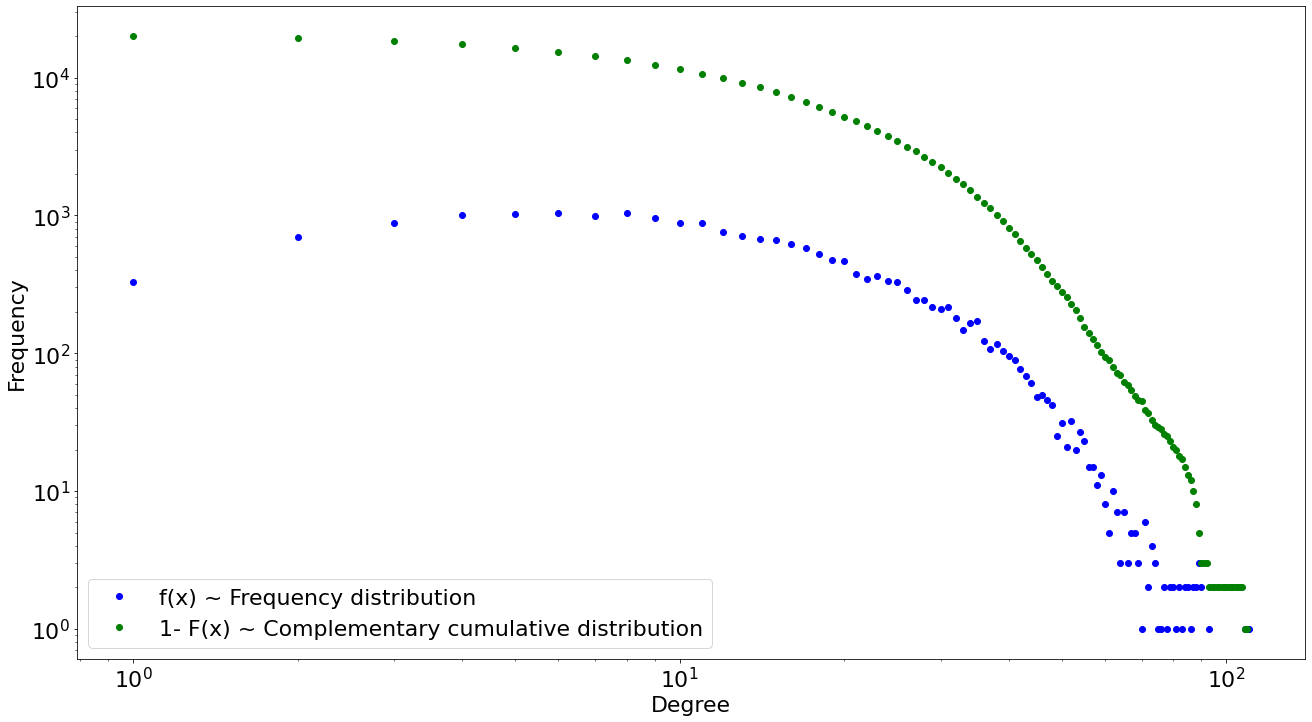

In [108]:
plot_degree_dist(degree_freq, degree_freq_cum_sum, complementary_degree_freq_cum_sum, degrees)

# Wyznacz wykładnik rozkładu potęgowego metodą regresji dla dopełnienia dystrybuanty rozkładu stopni, dla przedziałów rozlokowanych logarytmicznie

In [160]:
log_complementary_degree_freq_cum_sum = np.log(complementary_degree_freq_cum_sum[:-1])
log_degrees = np.log(degrees[1:])

logPk_interp = np.interp(log_degrees, log_degrees, log_complementary_degree_freq_cum_sum)
coef = np.polyfit(log_degrees, logPk_interp, 1)
poly1d_fn = np.poly1d(coef) 

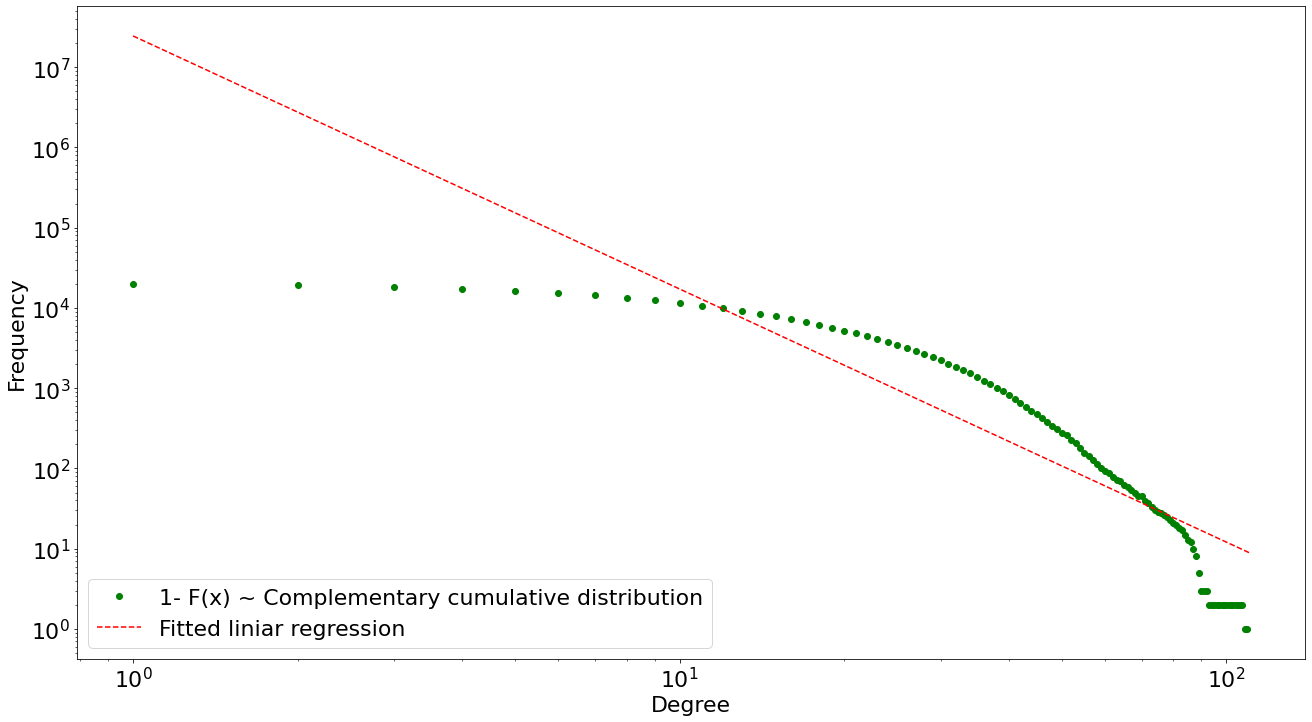

In [161]:
  plt.figure(figsize=(22, 12))
  plt.loglog(degrees, complementary_degree_freq_cum_sum,'go') 
  plt.loglog(degrees, np.exp(poly1d_fn(np.log(degrees))),'r--') 
  plt.xlabel('Degree')
  plt.ylabel('Frequency')
  plt.legend(['1- F(x) ~ Complementary cumulative distribution', 'Fitted liniar regression'], loc='lower left')

In [162]:
print(f'Wyznacznik dla rozkładu potęgowego: {-coef[0]}')

Wyznacznik dla rozkładu potęgowego: 3.154109267306761


# Draw graph

In [ ]:
import matplotlib.pyplot as plt

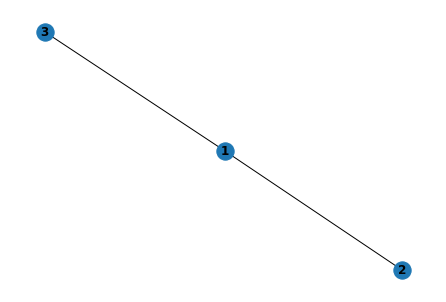

In [166]:
GG = nx.Graph()
GG.add_edges_from([(1, 2), (1, 3)])

nx.draw(GG, with_labels=True, font_weight='bold')


<Figure size 1584x864 with 0 Axes>

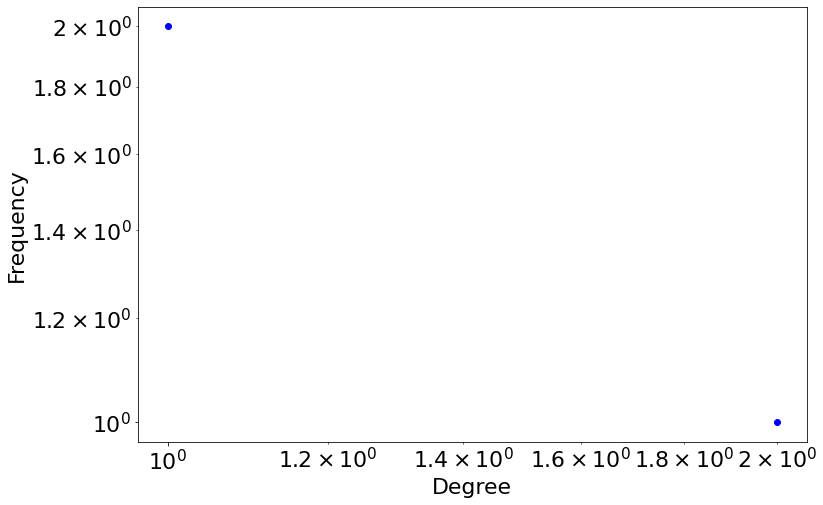

In [183]:
plot_degree_dist(GG)

In [ ]:
plt.show()  

In [143]:
GG = nx.Graph([(1,2),(1,3),(2,3)])
GG.add_edges_from([(10,20),(10,30),(20,30)])

In [144]:
GG_kc = nx.k_core(GG,k=2)

In [152]:
len({1: [1], 2: [2, 3, 4]})

2